# Reasoning Model Multi-Hop Comparison Report

This Jupyter notebook processes SEVAL job data and generates detailed multi-hop comparison reports on reasoning models across control and treatment experiments.

**Getting Started**: When you run the configuration cell (cell 4), you can modify the following settings:

1. **SEVAL Job ID** (e.g., '133560') – The job ID to analyze
2. **Data Paths** (optional) – Override the default paths if your SEVAL data is in a custom location:
   - `RAW_DATA_DIR` – Path to scraping raw data output
   - `METRICS_DIR` – Path to SEVAL metrics (CiteDCG labels)
3. **Top-k Values** – List of top-k values to analyze (e.g., [1, 3, 5]) for ranking metrics
4. **Clean Preprocessing** – Set `CLEAN_EXISTING = True` to force regeneration of preprocessing steps
 
**Default Data Structure**:
By default, the notebook expects data in the following structure:
```
seval_data/
  {job_id}_scraping_raw_data_output/    # Raw conversation data
  {job_id}_metrics/                      # CiteDCG metrics
```

You can override these paths if your data is located elsewhere (e.g., on a different drive or network location).

**What This Notebook Does**:
- Extracts CiteDCG scores from SEVAL metrics for both control and treatment
- Extracts conversation details and merges with CiteDCG scores
- Builds per-utterance statistics aggregated by hop index
- Creates comprehensive comparison plots showing:
  - Hop-by-hop score progression (including/excluding empty hops)
  - Single-hop vs multi-hop performance analysis
  - Control vs treatment experiment comparisons
- Exports detailed statistics to CSV for further analysis

**Prerequisites**: 
- SEVAL data must be downloaded and available locally (either in default location or custom path)

**Processing Behavior**:
- **Statistics plots are ALWAYS regenerated** for consistency and to reflect the latest data
- Preprocessing steps (CiteDCG extraction, conversation details, merged files) are reused by default for faster processing
- Set `CLEAN_EXISTING = True` to force complete regeneration of all preprocessing steps from scratch

**Output**: All results are saved to `results/{job_id}_statistics_plots/` including:
- Statistics JSON files with hop-level aggregations
- PNG plot images for visualization
- CSV exports for Excel/data analysis


In [5]:
# Automatically reload modules before executing user code
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

  %reload_ext autoreload


In [6]:
import os
import sys
import json
from pathlib import Path
from IPython.display import display, Markdown, Image

# Add the seval directory to the path
seval_dir = Path.cwd()
if str(seval_dir) not in sys.path:
    sys.path.insert(0, str(seval_dir))

# Add the workspace root to the path for utils module
workspace_root = seval_dir.parent.parent  # c:\working\BizChatScripts
if str(workspace_root) not in sys.path:
    sys.path.insert(0, str(workspace_root))

print(f"✓ Added to path: {seval_dir}")
print(f"✓ Added to path: {workspace_root}")
print("✓ Modules loaded successfully")

✓ Added to path: c:\working\BizChatScripts\projects\seval
✓ Added to path: c:\working\BizChatScripts
✓ Modules loaded successfully

✓ Added to path: c:\working\BizChatScripts
✓ Modules loaded successfully


In [7]:
# Configuration - Modify these values as needed
JOB_ID = "133560"
TOP_K_LIST = [1, 3, 5]  # Top-k values to analyze
THREADS = 16
CLEAN_EXISTING = False  # Set to True to regenerate preprocessing steps (CiteDCG, conversations, merged)
                         # Note: Statistics plots are ALWAYS regenerated

# Base directories
BASE_DIR = Path.cwd()
RESULTS_DIR = BASE_DIR / "results"

# SEVAL Data Paths - Override these if your data is in a different location
# Default paths assume standard directory structure:
#   seval_data/{job_id}_scraping_raw_data_output/
#   seval_data/{job_id}_metrics/
RAW_DATA_DIR = BASE_DIR / "seval_data" / f"{JOB_ID}_scraping_raw_data_output"
METRICS_DIR = BASE_DIR / "seval_data" / f"{JOB_ID}_metrics"

# Example: Override paths if data is located elsewhere
# RAW_DATA_DIR = Path("C:/my_data/seval/133560_scraping_raw_data_output")
# METRICS_DIR = Path("C:/my_data/seval/133560_metrics")

print(f"Configuration:")
print(f"  Job ID: {JOB_ID}")
print(f"  Experiment: both (control + treatment)")
print(f"  Top-k values: {TOP_K_LIST}")
print(f"  Raw data directory: {RAW_DATA_DIR}")
print(f"  Metrics directory: {METRICS_DIR}")
print(f"  Output directory: {RESULTS_DIR}")
print(f"  Clean preprocessing: {CLEAN_EXISTING}")
print()

# Verify paths exist
if not RAW_DATA_DIR.exists():
    print(f"⚠ Warning: Raw data directory not found: {RAW_DATA_DIR}")
if not METRICS_DIR.exists():
    print(f"⚠ Warning: Metrics directory not found: {METRICS_DIR}")
if RAW_DATA_DIR.exists() and METRICS_DIR.exists():
    print("✓ Data directories found")


Configuration:
  Job ID: 133560
  Experiment: both (control + treatment)
  Top-k values: [1, 3, 5]
  Raw data directory: c:\working\BizChatScripts\projects\seval\seval_data\133560_scraping_raw_data_output
  Metrics directory: c:\working\BizChatScripts\projects\seval\seval_data\133560_metrics
  Output directory: c:\working\BizChatScripts\projects\seval\results
  Clean preprocessing: False


  Job ID: 133560
  Experiment: both (control + treatment)
  Top-k values: [1, 3, 5]
  Raw data directory: c:\working\BizChatScripts\projects\seval\seval_data\133560_scraping_raw_data_output
  Metrics directory: c:\working\BizChatScripts\projects\seval\seval_data\133560_metrics
  Output directory: c:\working\BizChatScripts\projects\seval\results
  Clean preprocessing: False

✓ Data directories found
✓ Data directories found


## Step 1: Run Full SEVAL Processing Pipeline

This will execute all steps:
1. Extract CiteDCG scores from metrics (reused if CLEAN_EXISTING=False)
2. Extract conversation details from raw data (reused if CLEAN_EXISTING=False)
3. Merge CiteDCG scores with conversations (reused if CLEAN_EXISTING=False)
4. Build per-utterance details with hop-level scores (reused if CLEAN_EXISTING=False)
5. Generate statistics and plots (ALWAYS regenerated)

**Output Control**:
- The pipeline runs with `verbose=False` for a clean notebook experience
- Only essential progress messages are shown (what's being processed, completion status)
- Detailed processing logs are suppressed (file counts, threading details, etc.)
- To see full logs for debugging, change `verbose=False` to `verbose=True` in the cell below


In [8]:
# Run the pipeline with minimal output for notebook
print("="*80)
print(f"SEVAL JOB PROCESSING: {JOB_ID} (Control + Treatment)")
print("="*80)
print()

# Always clean the statistics plots directory
import shutil

stats_dir = RESULTS_DIR / f"{JOB_ID}_statistics_plots"

if stats_dir.exists():
    print(f"Cleaning statistics plots directory: {stats_dir}")
    shutil.rmtree(stats_dir)
    print("✓ Old plots and statistics deleted")
    print()

# Import and run the full pipeline
from seval_batch_processor import process_seval_job_with_statistics_plots

# Run the full pipeline
# verbose=False: Shows only essential progress messages (for notebook/end users)
# verbose=True: Shows detailed processing logs (for batch processing/developers)
# clean parameter controls whether to reuse preprocessing (CiteDCG, conversations, merged)
result = process_seval_job_with_statistics_plots(
    job_id=JOB_ID,
    experiment="both",
    top_k_list=TOP_K_LIST,
    raw_data_dir=str(RAW_DATA_DIR),
    metrics_dir=str(METRICS_DIR),
    output_base_dir=str(RESULTS_DIR),
    threads=THREADS,
    verbose=False,  # Minimal output for notebook users
    clean=CLEAN_EXISTING
)

print()
print("="*80)
print("✓ PROCESSING COMPLETE - READY TO DISPLAY RESULTS")
print("="*80)


SEVAL JOB PROCESSING: 133560 (Control + Treatment)


SEVAL JOB PROCESSING: 133560 (Control + Treatment)



STEP 4-1: BUILDING PER-UTTERANCE DETAILS
STEP 4-1: BUILDING PER-UTTERANCE DETAILS

STEP 4-2: FINDING PAIRED UTTERANCES WITH SCORES

STEP 4-2: FINDING PAIRED UTTERANCES WITH SCORES
    Total unique queries: 1309
    ✓ Paired (scores in both): 741 (56.6%)
    • Control only: 324
    • Treatment only: 70
    • No scores: 174

STEP 5: GENERATING PLOTS AND PLOT-SPECIFIC STATISTICS    Total unique queries: 1309
    ✓ Paired (scores in both): 741 (56.6%)
    • Control only: 324
    • Treatment only: 70
    • No scores: 174

STEP 5: GENERATING PLOTS AND PLOT-SPECIFIC STATISTICS

  Generating 2x2 comparison plots...
  Generating 2x2 comparison plots...
  ✓ Saved: 133560_comparison_by_hop_index.png
  ✓ Saved: 133560_comparison_by_hop_index.png
  ✓ Saved: 133560_comparison_by_hop_sequence.png
  ✓ Saved: 133560_comparison_by_hop_sequence.png
  ✓ Saved: 133560_comparison_single_vs_multi_hop.pn

## Step 2: Display Generated Statistics

View the statistics for each experiment and top-k value.

In [9]:
# Display statistics summary
stats_dir = RESULTS_DIR / f"{JOB_ID}_statistics_plots"

def display_stats_summary(stats_file):
    """Display summary statistics from a stats JSON file."""
    with open(stats_file, 'r', encoding='utf-8') as f:
        stats = json.load(f)
    
    print(f"\nStatistics from: {stats_file.name}")
    print("="*60)
    print(f"Top-k: {stats.get('top_k')}")
    print(f"Total utterances: {stats.get('total_utterances')}")
    print(f"Utterances with scores: {stats.get('utterances_with_scores')}")
    
    # Per-hop statistics
    per_hop = stats.get('per_hop', {})
    if per_hop:
        print(f"\nPer-Hop Statistics (first 5 hops):")
        for hop in sorted([int(h) for h in per_hop.keys()])[:5]:
            hop_data = per_hop[str(hop)]
            avg = hop_data.get('avg_all_scores')
            count = hop_data.get('utterances_with_scores', 0)
            avg_str = f"{avg:.4f}" if avg is not None else "N/A"
            print(f"  Hop {hop}: avg={avg_str}, count={count}")
    
    # Single vs Multi-hop
    single = stats.get('single_hop', {})
    multi = stats.get('multi_hop', {})
    if single:
        single_data = single.get('1', {})
        print(f"\nSingle-hop utterances: {single_data.get('utterances_count', 0)}")
        print(f"  Avg score: {single_data.get('avg_all_scores', 0):.4f}")
    if multi:
        multi_count = sum(h.get('utterances_count', 0) for h in multi.values())
        print(f"Multi-hop utterances: {multi_count}")

# Display stats for each experiment and k-value
if stats_dir.exists():
    for stats_file in sorted(stats_dir.glob("*_plot_stats_k*.json")):
        display_stats_summary(stats_file)
else:
    print(f"Statistics directory not found: {stats_dir}")



Statistics from: 133560_control_plot_stats_k1.json
Top-k: 1
Total utterances: 1309
Utterances with scores: 1065

Per-Hop Statistics (first 5 hops):
  Hop 1: avg=1.2667, count=1001
  Hop 2: avg=1.1982, count=356
Top-k: 1
Total utterances: 1309
Utterances with scores: 1065

Per-Hop Statistics (first 5 hops):
  Hop 1: avg=1.2667, count=1001
  Hop 2: avg=1.1982, count=356
  Hop 3: avg=1.3937, count=170
  Hop 4: avg=1.2651, count=83
  Hop 5: avg=1.4745, count=64

Single-hop utterances: 689
  Avg score: 1.3534
  Hop 3: avg=1.3937, count=170
  Hop 4: avg=1.2651, count=83
  Hop 5: avg=1.4745, count=64

Single-hop utterances: 689
  Avg score: 1.3534
Multi-hop utterances: 1168

Multi-hop utterances: 1168

Statistics from: 133560_control_plot_stats_k3.json
Top-k: 3
Total utterances: 1309
Statistics from: 133560_control_plot_stats_k3.json
Top-k: 3
Total utterances: 1309
Utterances with scores: 1065

Per-Hop Statistics (first 5 hops):
  Hop 1: avg=1.2667, count=1001
  Hop 2: avg=1.1982, count=356


## Step 3: Display Generated Plots

View the comparison plots generated by the pipeline.


133560_comparison_by_hop_index.png



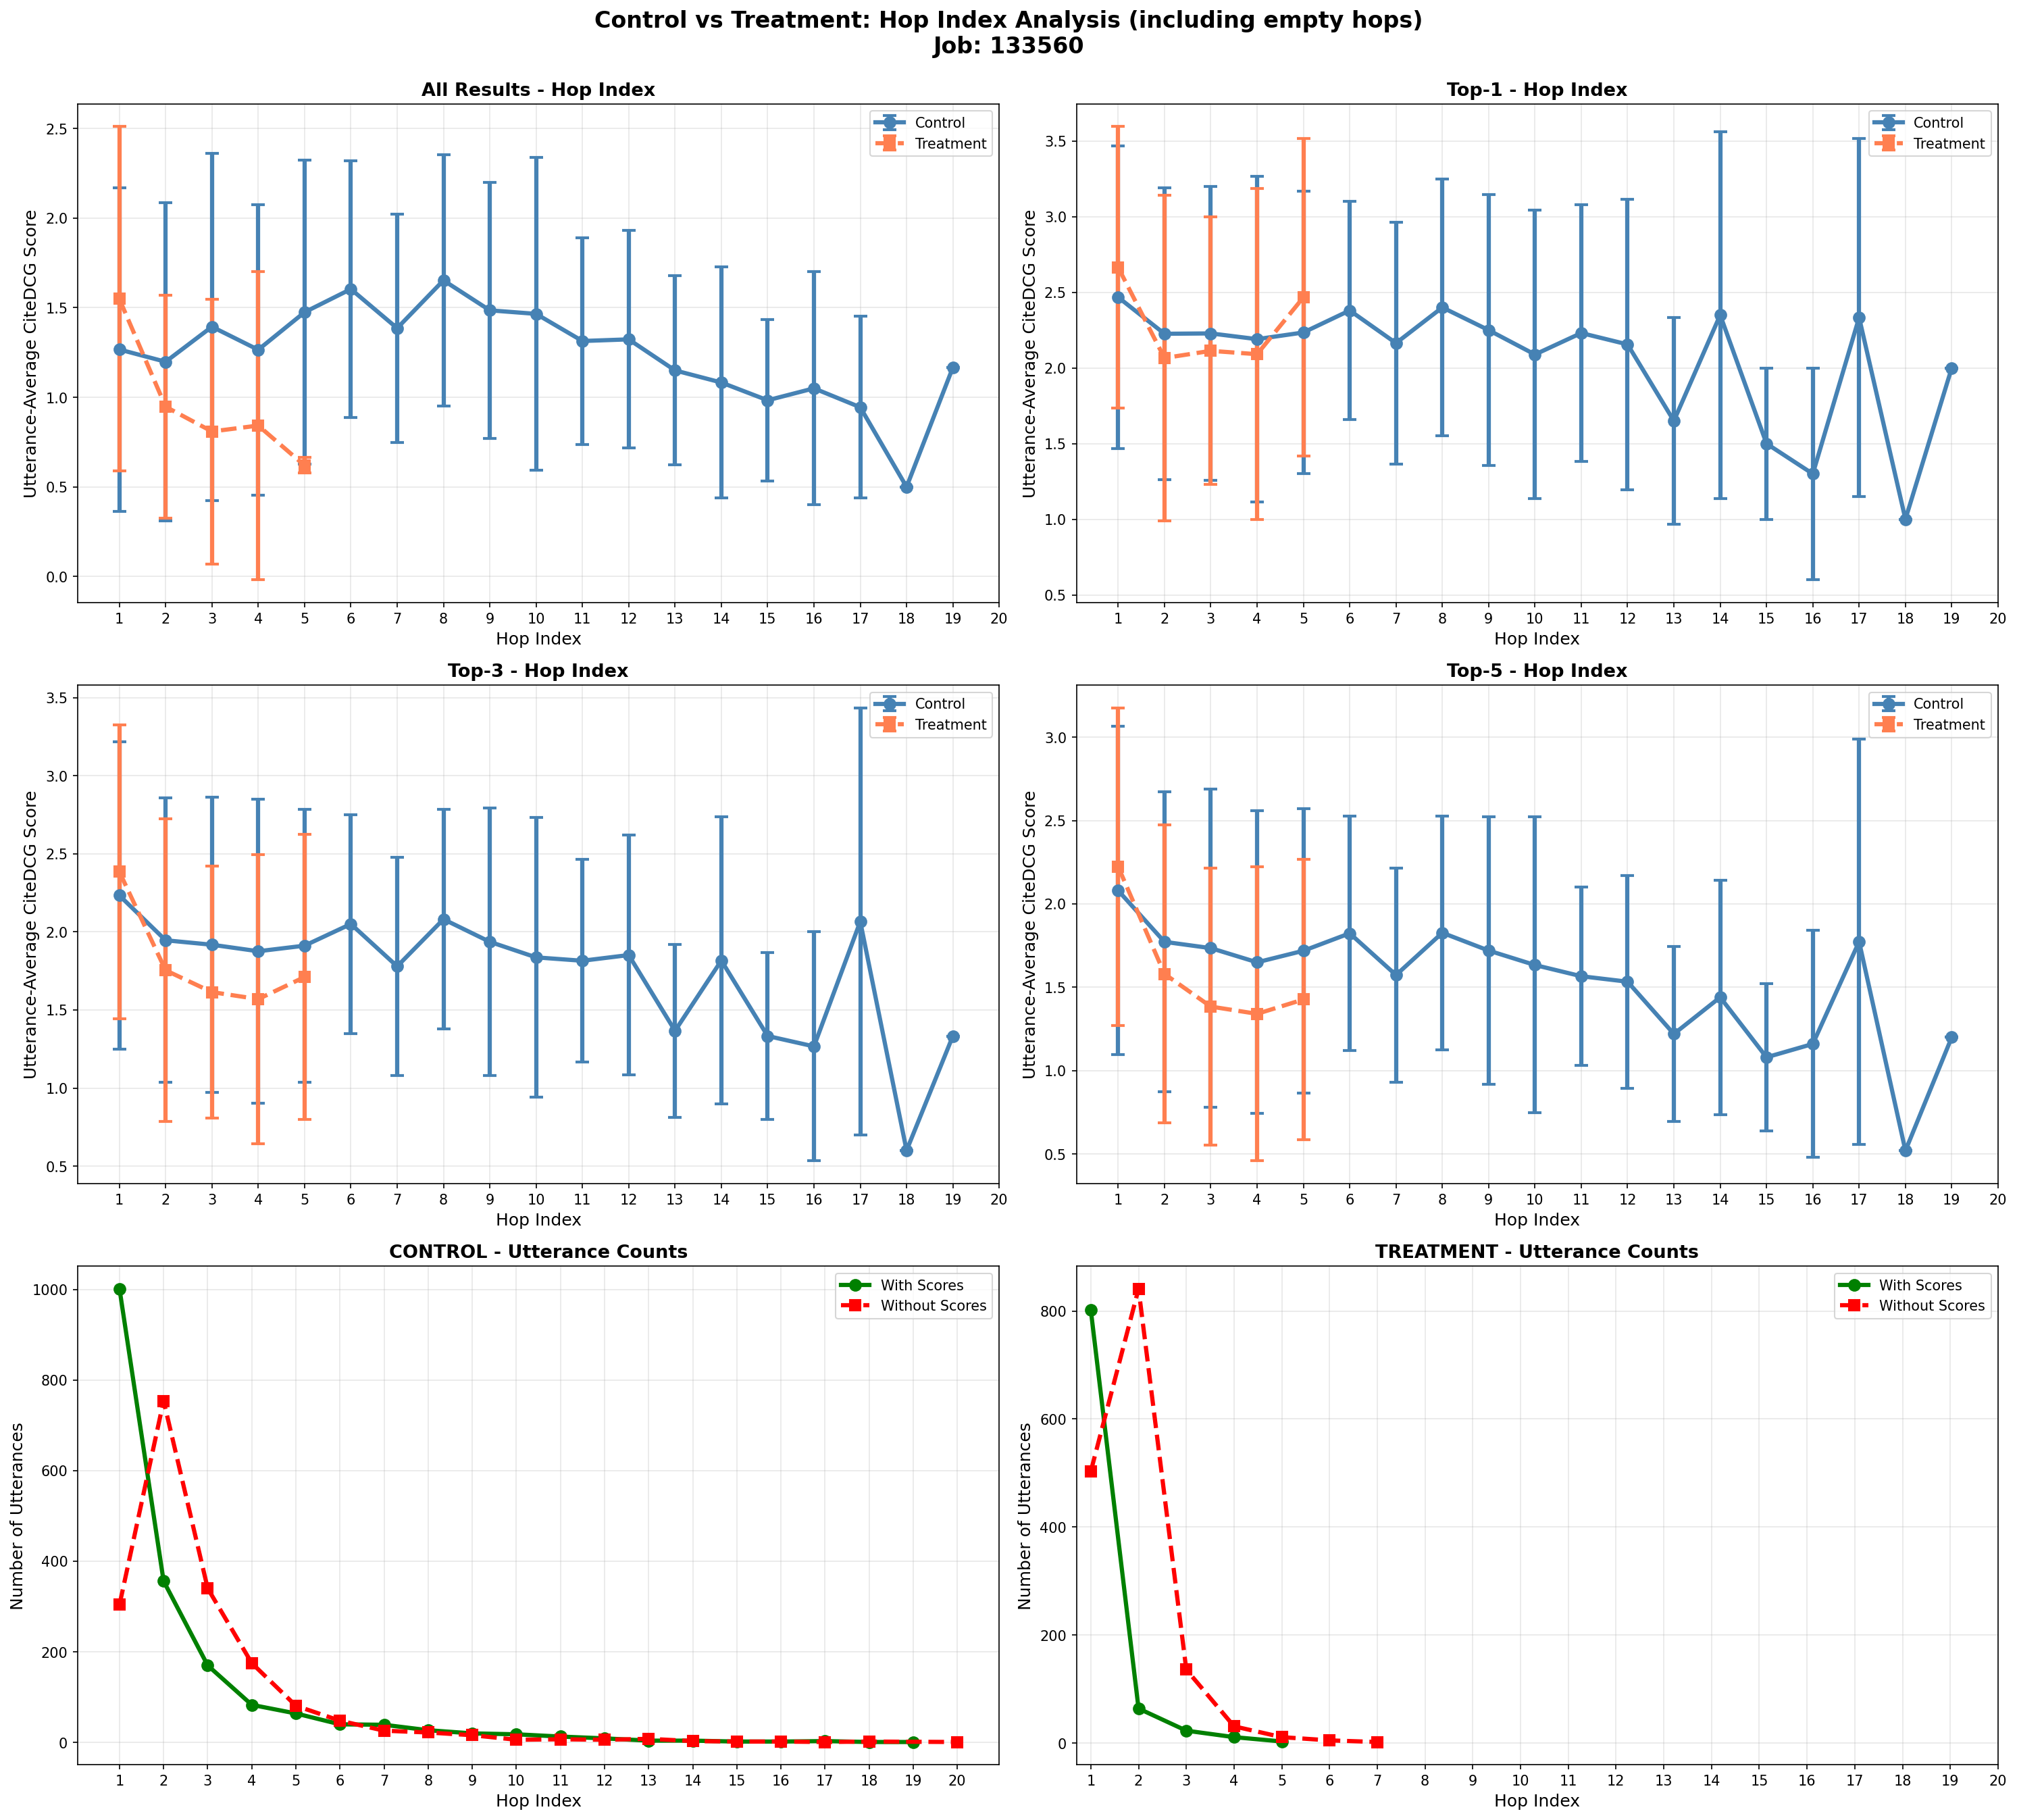


133560_comparison_by_hop_sequence.png



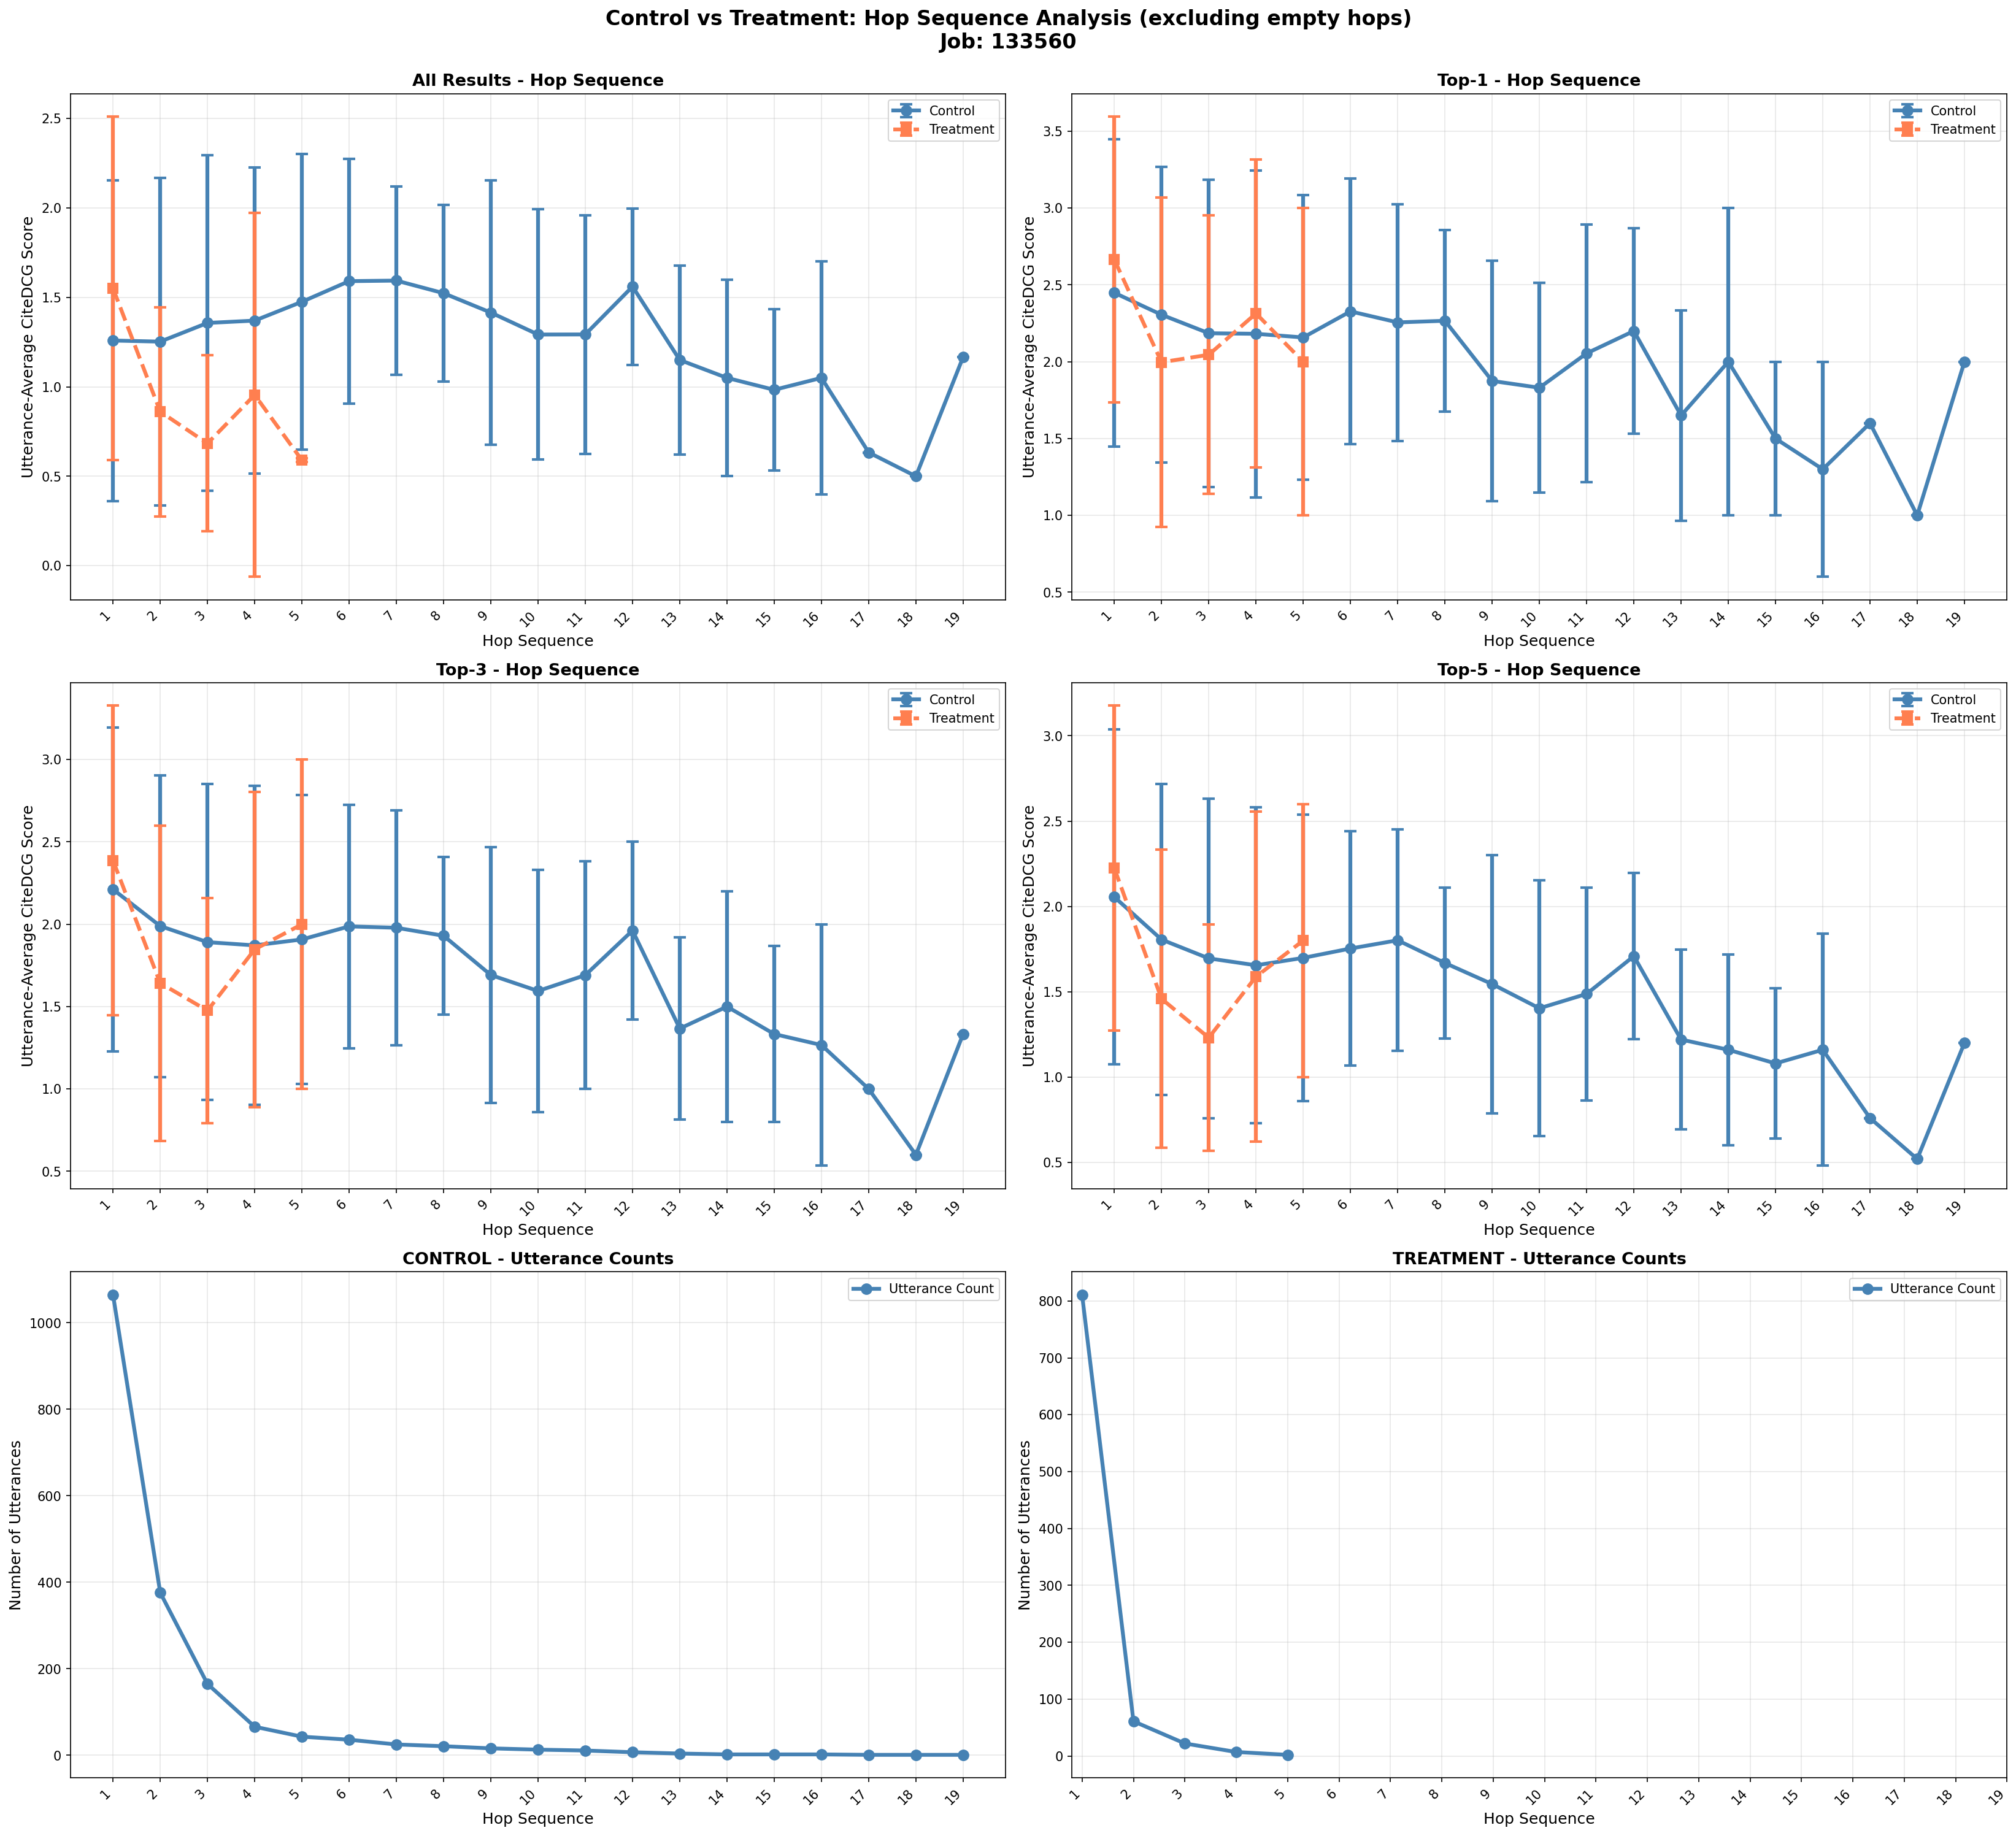


133560_comparison_single_vs_multi_hop.png



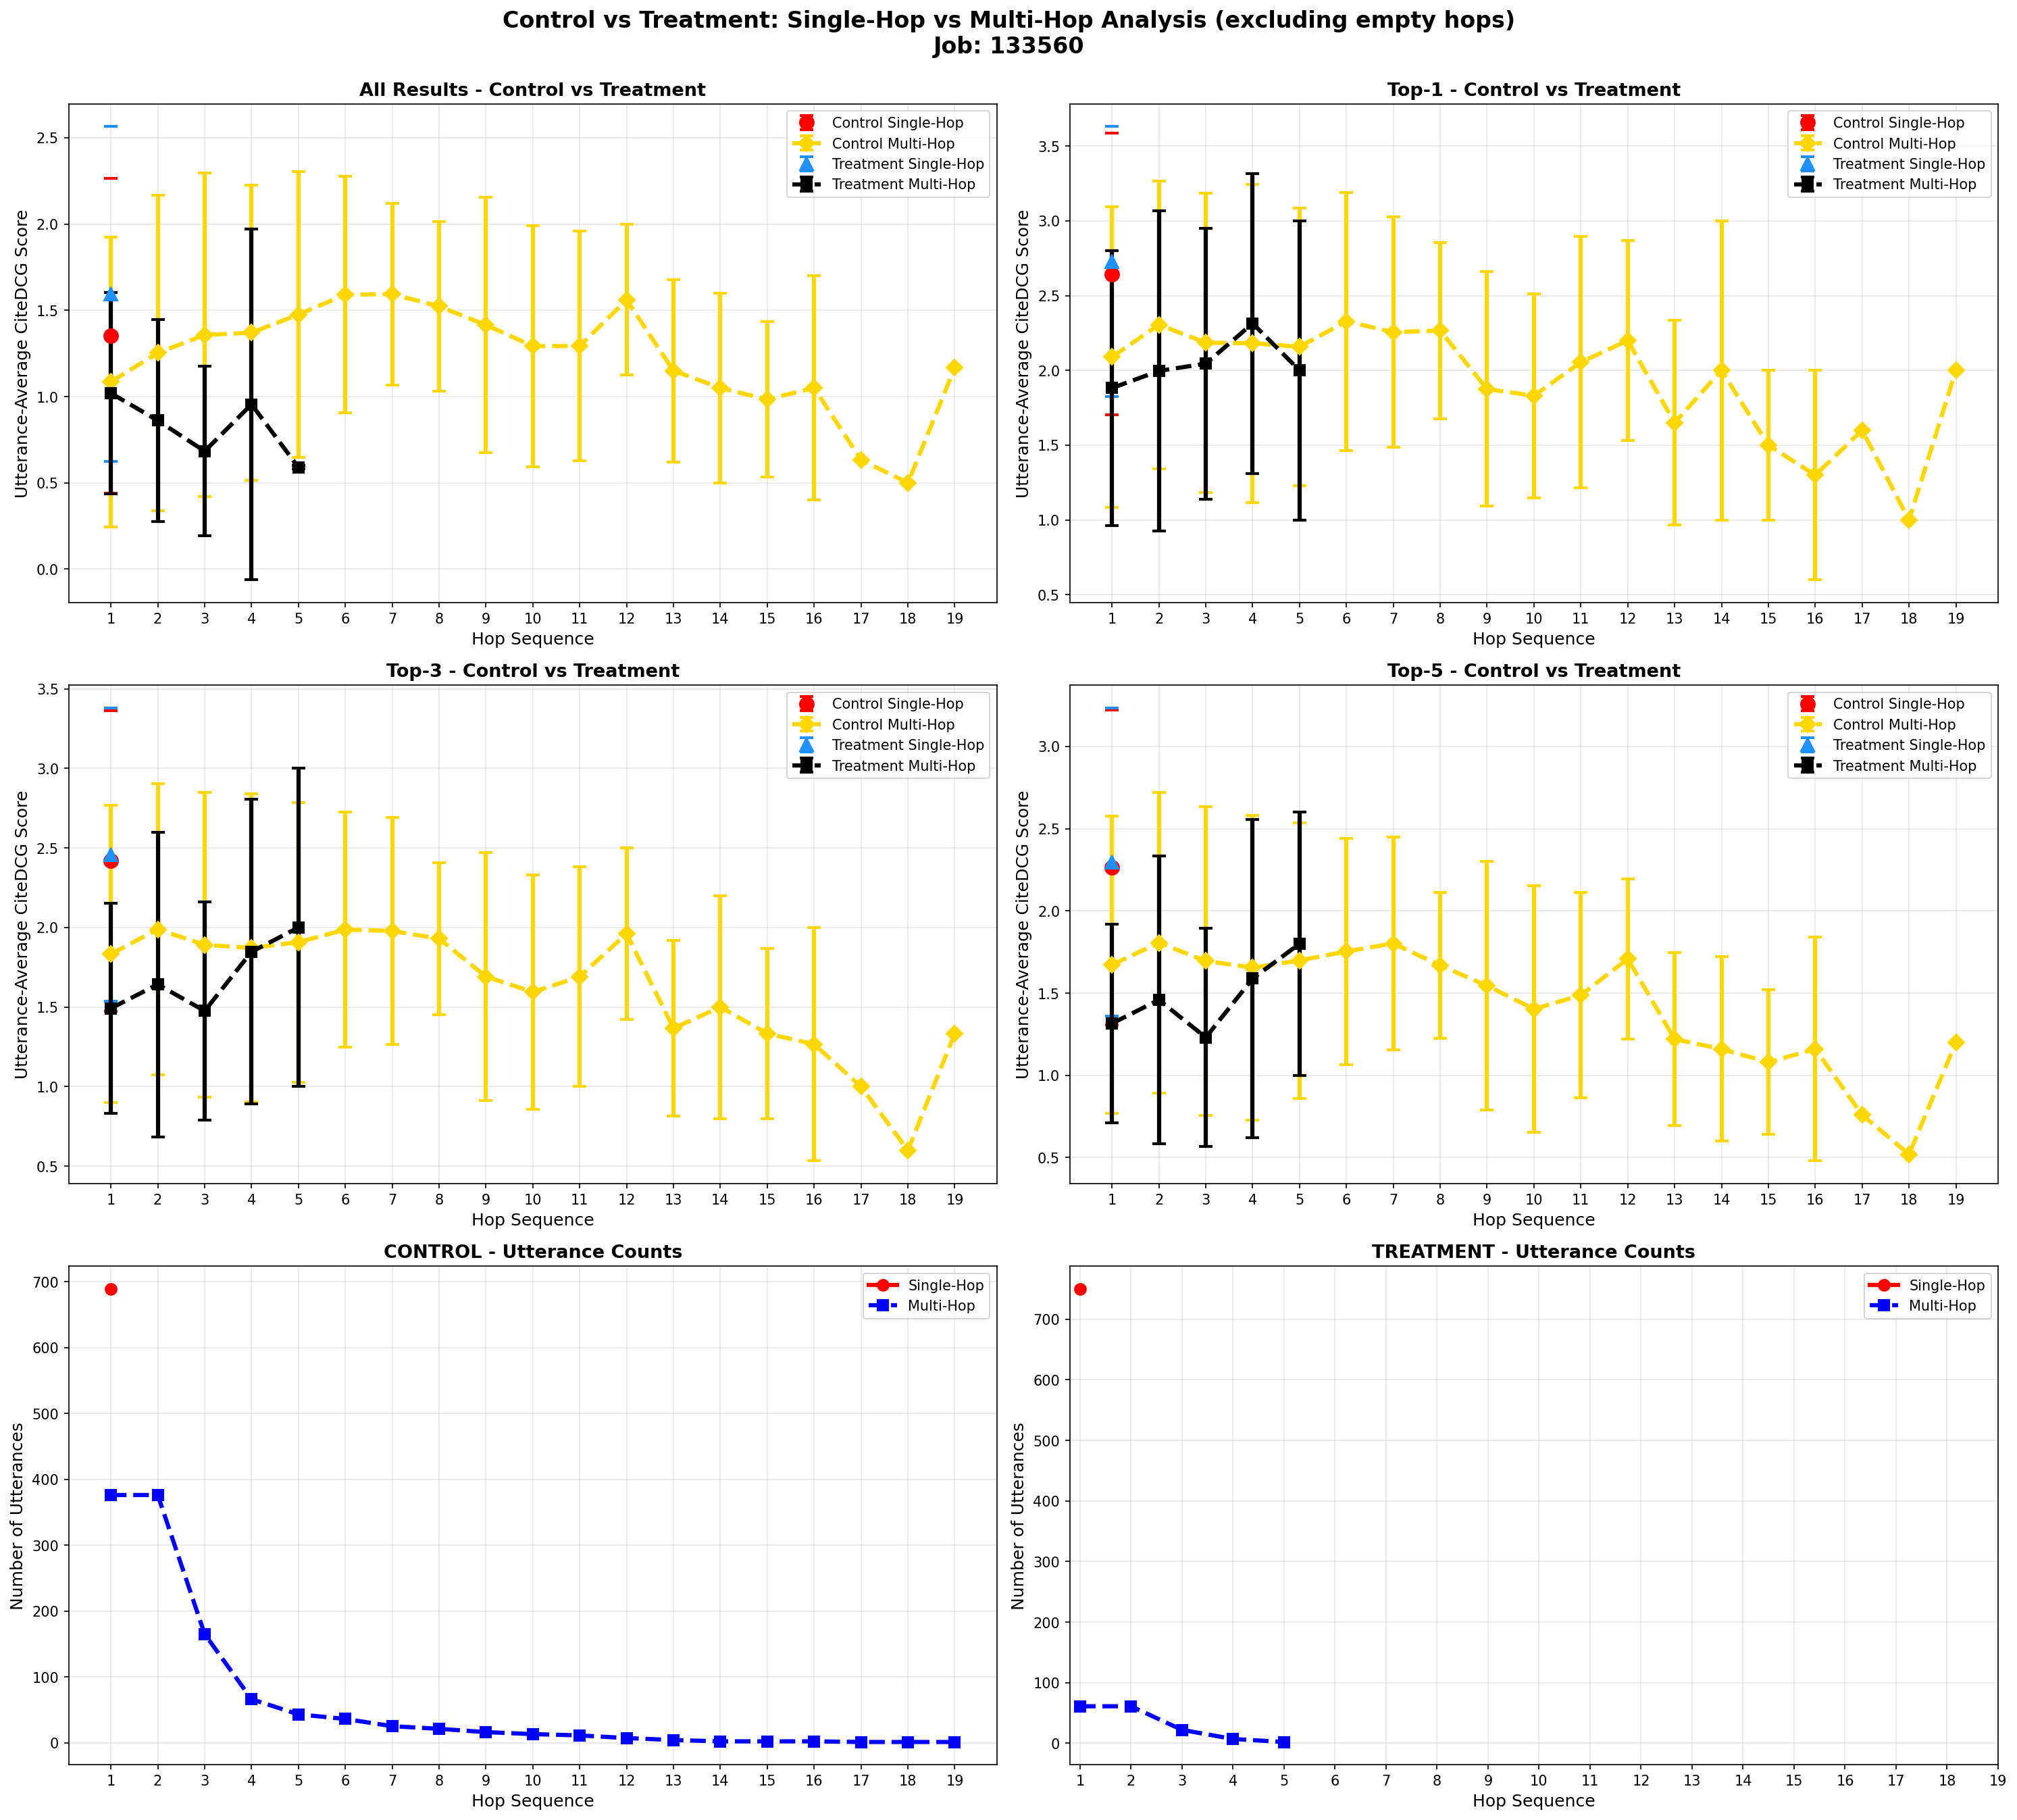

In [10]:
# Display generated plots (excluding paired utterances plot)
if stats_dir.exists():
    # Get all plots except the paired utterances plot
    all_plots = sorted(stats_dir.glob("*.png"))
    plot_files = [p for p in all_plots if 'paired' not in p.name.lower()]
    
    for plot_file in plot_files:
        print(f"\n{plot_file.name}")
        print("="*60)
        display(Image(filename=str(plot_file)))
else:
    print(f"Plots directory not found: {stats_dir}")

## Step 4: Detailed Statistics Analysis

Examine specific statistics in detail.

In [11]:
# Load and analyze specific statistics
def analyze_hop_statistics(experiment, k_value):
    """Analyze hop-level statistics for a specific experiment and k-value."""
    stats_file = stats_dir / f"{JOB_ID}_{experiment}_plot_stats_k{k_value}.json"
    
    if not stats_file.exists():
        print(f"Stats file not found: {stats_file}")
        return
    
    with open(stats_file, 'r', encoding='utf-8') as f:
        stats = json.load(f)
    
    print(f"\nDetailed Hop Statistics: {experiment.upper()} (k={k_value})")
    print("="*80)
    
    per_hop = stats.get('per_hop', {})
    
    # Create summary table
    print(f"{'Hop':<6} {'Avg Score':<12} {'Std Dev':<12} {'With Scores':<15} {'Without Scores':<15} {'Total':<10}")
    print("-"*80)
    
    for hop in sorted([int(h) for h in per_hop.keys()]):
        hop_data = per_hop[str(hop)]
        avg = hop_data.get('avg_all_scores')
        std = hop_data.get('std_all_scores')
        with_scores = hop_data.get('utterances_with_scores', 0)
        without_scores = hop_data.get('utterances_without_scores', 0)
        total = hop_data.get('total_utterances', 0)
        
        avg_str = f"{avg:.4f}" if avg is not None else "N/A"
        std_str = f"{std:.4f}" if std is not None else "N/A"
        
        print(f"{hop:<6} {avg_str:<12} {std_str:<12} {with_scores:<15} {without_scores:<15} {total:<10}")

# Analyze statistics for both control and treatment experiments
experiments = ['control', 'treatment']
for exp in experiments:
    for k in TOP_K_LIST:
        analyze_hop_statistics(exp, k)


Detailed Hop Statistics: CONTROL (k=1)
Hop    Avg Score    Std Dev      With Scores     Without Scores  Total     
--------------------------------------------------------------------------------
1      1.2667       0.9025       1001            304             1305      
2      1.1982       0.8883       356             754             1110      
3      1.3937       0.9687       170             340             510       

Hop    Avg Score    Std Dev      With Scores     Without Scores  Total     
--------------------------------------------------------------------------------
1      1.2667       0.9025       1001            304             1305      
2      1.1982       0.8883       356             754             1110      
3      1.3937       0.9687       170             340             510       
4      1.2651       0.8110       83              175             258       
5      1.4745       0.8473       64              81              145       
6      1.6037       0.7147       40  

## Step 5: Export Statistics to CSV (Optional)

Export statistics to CSV format for further analysis in Excel or other tools.

In [12]:
import pandas as pd

def export_statistics_to_csv(experiment, k_value):
    """Export hop statistics to CSV."""
    stats_file = stats_dir / f"{JOB_ID}_{experiment}_plot_stats_k{k_value}.json"
    
    if not stats_file.exists():
        print(f"Stats file not found: {stats_file}")
        return
    
    with open(stats_file, 'r', encoding='utf-8') as f:
        stats = json.load(f)
    
    per_hop = stats.get('per_hop', {})
    
    # Create DataFrame
    rows = []
    for hop in sorted([int(h) for h in per_hop.keys()]):
        hop_data = per_hop[str(hop)]
        rows.append({
            'Hop': hop,
            'Avg_All_Scores': hop_data.get('avg_all_scores'),
            'Std_All_Scores': hop_data.get('std_all_scores'),
            'Avg_TopK_Scores': hop_data.get('avg_topk_scores'),
            'Std_TopK_Scores': hop_data.get('std_topk_scores'),
            'Utterances_With_Scores': hop_data.get('utterances_with_scores', 0),
            'Utterances_Without_Scores': hop_data.get('utterances_without_scores', 0),
            'Total_Utterances': hop_data.get('total_utterances', 0)
        })
    
    df = pd.DataFrame(rows)
    
    # Save to CSV
    csv_file = stats_dir / f"{JOB_ID}_{experiment}_hop_stats_k{k_value}.csv"
    df.to_csv(csv_file, index=False)
    print(f"✓ Exported to: {csv_file}")
    
    return df

# Export for all experiments and k-values
for exp in experiments:
    for k in TOP_K_LIST:
        df = export_statistics_to_csv(exp, k)
        if df is not None:
            display(Markdown(f"### {exp.upper()} - Top-{k}"))
            display(df.head(10))

✓ Exported to: c:\working\BizChatScripts\projects\seval\results\133560_statistics_plots\133560_control_hop_stats_k1.csv



### CONTROL - Top-1

,Hop,Avg_All_Scores,Std_All_Scores,Avg_TopK_Scores,Std_TopK_Scores,Utterances_With_Scores,Utterances_Without_Scores,Total_Utterances
0,1,1.266666,0.902514,2.467433,0.998710,1001,304,1305
1,2,1.198197,0.888348,2.225843,0.965504,356,754,1110
2,3,1.393688,0.968684,2.228235,0.970944,170,340,510
3,4,1.265103,0.811007,2.190361,1.076766,83,175,258
4,5,1.474454,0.847350,2.234375,0.934448,64,81,145
5,6,1.603653,0.714689,2.380000,0.720833,40,48,88
6,7,1.385595,0.637637,2.164103,0.799836,39,26,65
7,8,1.652416,0.700411,2.400000,0.848528,27,22,49
8,9,1.485152,0.713010,2.250000,0.894148,20,16,36
9,10,1.465450,0.871976,2.088889,0.952709,18,6,24


✓ Exported to: c:\working\BizChatScripts\projects\seval\results\133560_statistics_plots\133560_control_hop_stats_k3.csv



### CONTROL - Top-3

,Hop,Avg_All_Scores,Std_All_Scores,Avg_TopK_Scores,Std_TopK_Scores,Utterances_With_Scores,Utterances_Without_Scores,Total_Utterances
0,1,1.266666,0.902514,2.234166,0.985096,1001,304,1305
1,2,1.198197,0.888348,1.946536,0.911097,356,754,1110
2,3,1.393688,0.968684,1.918039,0.946394,170,340,510
3,4,1.265103,0.811007,1.876305,0.971957,83,175,258
4,5,1.474454,0.847350,1.911979,0.873120,64,81,145
5,6,1.603653,0.714689,2.050833,0.701902,40,48,88
6,7,1.385595,0.637637,1.779487,0.697599,39,26,65
7,8,1.652416,0.700411,2.081481,0.702338,27,22,49
8,9,1.485152,0.713010,1.936667,0.856732,20,16,36
9,10,1.465450,0.871976,1.837037,0.895592,18,6,24


✓ Exported to: c:\working\BizChatScripts\projects\seval\results\133560_statistics_plots\133560_control_hop_stats_k5.csv



### CONTROL - Top-5

,Hop,Avg_All_Scores,Std_All_Scores,Avg_TopK_Scores,Std_TopK_Scores,Utterances_With_Scores,Utterances_Without_Scores,Total_Utterances
0,1,1.266666,0.902514,2.080020,0.983949,1001,304,1305
1,2,1.198197,0.888348,1.772406,0.900477,356,754,1110
2,3,1.393688,0.968684,1.734627,0.954845,170,340,510
3,4,1.265103,0.811007,1.649639,0.907258,83,175,258
4,5,1.474454,0.847350,1.718802,0.852680,64,81,145
5,6,1.603653,0.714689,1.823500,0.703376,40,48,88
6,7,1.385595,0.637637,1.573333,0.642133,39,26,65
7,8,1.652416,0.700411,1.826667,0.701237,27,22,49
8,9,1.485152,0.713010,1.720000,0.802496,20,16,36
9,10,1.465450,0.871976,1.633333,0.887168,18,6,24


✓ Exported to: c:\working\BizChatScripts\projects\seval\results\133560_statistics_plots\133560_treatment_hop_stats_k1.csv



### TREATMENT - Top-1

,Hop,Avg_All_Scores,Std_All_Scores,Avg_TopK_Scores,Std_TopK_Scores,Utterances_With_Scores,Utterances_Without_Scores,Total_Utterances
0,1,1.549082,0.960969,2.664464,0.930662,802,503,1305
1,2,0.947325,0.621433,2.065625,1.075322,64,841,905
2,3,0.809382,0.739107,2.113043,0.884310,23,136,159
3,4,0.842357,0.860209,2.090909,1.093331,11,31,42
4,5,0.620000,0.043205,2.466667,1.049868,3,11,14
5,6,NaN,NaN,NaN,NaN,0,5,5
6,7,NaN,NaN,NaN,NaN,0,2,2


✓ Exported to: c:\working\BizChatScripts\projects\seval\results\133560_statistics_plots\133560_treatment_hop_stats_k3.csv



### TREATMENT - Top-3

,Hop,Avg_All_Scores,Std_All_Scores,Avg_TopK_Scores,Std_TopK_Scores,Utterances_With_Scores,Utterances_Without_Scores,Total_Utterances
0,1,1.549082,0.960969,2.386035,0.941245,802,503,1305
1,2,0.947325,0.621433,1.754167,0.969097,64,841,905
2,3,0.809382,0.739107,1.614493,0.805286,23,136,159
3,4,0.842357,0.860209,1.569697,0.927847,11,31,42
4,5,0.620000,0.043205,1.711111,0.913006,3,11,14
5,6,NaN,NaN,NaN,NaN,0,5,5
6,7,NaN,NaN,NaN,NaN,0,2,2


✓ Exported to: c:\working\BizChatScripts\projects\seval\results\133560_statistics_plots\133560_treatment_hop_stats_k5.csv



### TREATMENT - Top-5

,Hop,Avg_All_Scores,Std_All_Scores,Avg_TopK_Scores,Std_TopK_Scores,Utterances_With_Scores,Utterances_Without_Scores,Total_Utterances
0,1,1.549082,0.960969,2.222772,0.953369,802,503,1305
1,2,0.947325,0.621433,1.579948,0.892379,64,841,905
2,3,0.809382,0.739107,1.384130,0.829841,23,136,159
3,4,0.842357,0.860209,1.340606,0.881750,11,31,42
4,5,0.620000,0.043205,1.426667,0.839894,3,11,14
5,6,NaN,NaN,NaN,NaN,0,5,5
6,7,NaN,NaN,NaN,NaN,0,2,2


## Summary

This notebook has:
1. ✓ Processed SEVAL job data through the complete pipeline
2. ✓ Generated statistics for multiple top-k values
3. ✓ Created comparison plots (hop index, hop sequence, single vs multi-hop)
4. ✓ Displayed statistics and visualizations
5. ✓ Exported data to CSV for further analysis

**Output Files:**
- Statistics JSON files: `results/{JOB_ID}_statistics_plots/*_plot_stats_k*.json`
- Plot images: `results/{JOB_ID}_statistics_plots/*.png`
- CSV exports: `results/{JOB_ID}_statistics_plots/*_hop_stats_k*.csv`